Task 1: Define and implement a “design creation to export” metric
a.	Please take a deeper look at the design events dataset! Run an exploratory data analysis to understand what the data represents! Summarize your understanding, findings and insights!
b.	Define a  “design creation to export” rate you would use!
c.	What are your insights and learnings from the analyses? How would you present it to your team and Product manager?

#### Additional info based on my research on understanding the product.

#### Typical User Workflow in Shapr3D:

##### 1. Creating a Design
The user **starts a new project** in Shapr3D. Not all created designs are developed further.This could be a quick test or an actual product design.  

##### 2. Modifying the Design  
Renaming suggests the user **organizes their work**. Usually happens when the user sees value in their design and wants to save it properly.  

##### 3. Opening & Working on the Design
Users **revisit their projects multiple times**, meaning they are **actively working** on designs over multiple sessions. Indicates engagement with the software.  

##### 4. Exporting the Design  
Shows the intention of **using the design outside** Shapr3D (e.g., for manufacturing, 3D printing, or sharing). Indicates **serious usage** rather than just testing the tool.  

In [3]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

import sqlite3
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
design_events = pd.read_csv(r"C:\Users\lily\Desktop\DS interview prep\Interviews\Shapr3D\DA_homework_files_design_events.csv")
#design_events = pd.read_csv('/content/DA_home_task_files_design_events.csv')

#### SQLite EDA

*Colum names extraction*

In [5]:
design_events.columns

Index(['event_name', 'device_platform', 'event_time', 'user_id',
       'active_team_id', 'app_version', 'workspace_id', 'workspace_uuid',
       'file_format', 'resolution'],
      dtype='object')

*Connect to SQLite - automatical database file creation* 

*Create an in-memory database*

In [6]:
conn = sqlite3.connect("shapr3d.db")
cursor = conn.cursor()

*Data load into SQLite table called design_events*

In [7]:
#This loads the dataset into SQLite without modifications.
design_events.to_sql("temp_events", conn, if_exists="replace", index=False)

73008

*Create the SQLite table (inside of the database) for efficient queries and adding primary key*

In [8]:
cursor.execute("""
    CREATE TABLE events (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        event_name TEXT,
        device_platform TEXT,
        event_time TEXT,
        user_id TEXT,
        active_team_id TEXT,
        app_version TEXT,
        workspace_id TEXT,
        workspace_uuid TEXT,
        file_format TEXT,
        resolution TEXT
    )
""")

cursor.execute("""
    INSERT INTO events (event_name, device_platform, event_time, user_id, active_team_id, app_version, workspace_id, workspace_uuid, file_format, resolution)
    SELECT event_name, device_platform, event_time, user_id, active_team_id, app_version, workspace_id, workspace_uuid, file_format, resolution 
    FROM temp_events
""")

#Simple Queries Don't Need Triple Quotes
cursor.execute("DROP TABLE temp_events")
conn.commit()

#### Table rows & columns

In [9]:
cursor.execute('''
    SELECT COUNT(*)
    FROM events
''')

rows = cursor.fetchone()[0]
rows

73008

In [10]:
cursor.execute("SELECT * FROM events LIMIT 2")
rows = cursor.fetchall()
for row in rows:
    print(row)

(1, 'design_created', 'Windows', '2024-11-26 07:55:47.896000', '84d9a7e6-e84e-4498-b963-ab37f2422054', 'd34a926b-76c3-4f25-9fd7-c1bfdb45aebc', '5.650.7126.0', None, 'fdb471ff-6a91-49aa-8d33-e9cf129ad978', None, None)
(2, 'design_created', 'Windows', '2024-10-23 14:54:54.831000', '47405968-d781-4fa1-8f63-85e54b58a7bc', 'd56aa67d-6879-46e7-bb20-3a086fcb0050', '5.730.7613.0', None, '2b586791-b98e-4ba7-8c27-c2ac1cb28918', None, None)


In [11]:
cursor.execute('''
    SELECT *
    FROM events
    LIMIT 1
''')

#cursor.description is an attribute of a database cursor - ATTRIBUTE
column_names = [description[0] for description in cursor.description]
column_names

['id',
 'event_name',
 'device_platform',
 'event_time',
 'user_id',
 'active_team_id',
 'app_version',
 'workspace_id',
 'workspace_uuid',
 'file_format',
 'resolution']

#### Checking for duplicates

In [12]:
cursor.execute('''
SELECT COUNT(*)
FROM (
    SELECT COUNT(*)
    FROM events
    GROUP BY event_name, device_platform, event_time, user_id, active_team_id, app_version, workspace_id, workspace_uuid, file_format, resolution
    HAVING COUNT(*) > 1
) AS duplicates
''')

duplicates = cursor.fetchone()[0]
duplicates

44

#### Deleting duplications

In [13]:
# Common Table Expression (CTE)
# From each duplicate group, it selects the minimum ROWID the "first" row to keep 

cursor.execute('''
WITH Duplicates AS (
    SELECT MIN(ROWID) AS keep_rowid
    FROM events
    GROUP BY event_name, device_platform, event_time, user_id, active_team_id, app_version, workspace_id, workspace_uuid, file_format, resolution
    HAVING COUNT(*) > 1
)

DELETE FROM events
WHERE ROWID NOT IN (
    SELECT MIN(ROWID)
    FROM events
    GROUP BY event_name, device_platform, event_time, user_id, active_team_id, app_version, workspace_id, workspace_uuid, file_format, resolution
)
''')
#All the unique rows in the nested query
#The ROWID NOT IN (...) part means "delete all rows whose ROWID is not in the list returned by the inner query"
conn.commit()

In [14]:
cursor.execute('''
    SELECT COUNT(*)
    FROM events
''')

rows02 = cursor.fetchone()[0]
rows02

72964

#### Checking for non-null values

In [15]:
query = '''
SELECT
    COUNT(event_name) AS count_event_name,
    COUNT(device_platform) AS count_device_platform,
    COUNT(event_time) AS count_event_time,
    COUNT(user_id) AS count_user_id,
    COUNT(active_team_id) AS count_active_team_id,
    COUNT(app_version) AS count_app_version,
    COUNT(workspace_id) AS count_workspace_id,
    COUNT(workspace_uuid) AS count_workspace_uuid,
    COUNT(file_format) AS count_file_format,
    COUNT(resolution) AS count_resolution
FROM events;
'''

cursor.execute(query)

non_null_values = cursor.fetchall()

columns = [
    'event_name', 'device_platform', 'event_time', 'user_id',
    'active_team_id', 'app_version', 'workspace_id', 'workspace_uuid',
    'file_format', 'resolution'
]

non_null = pd.DataFrame(non_null_values, columns=columns)

print("\nNon-null values in each column:")
non_null



Non-null values in each column:


,event_name,device_platform,event_time,user_id,active_team_id,app_version,workspace_id,workspace_uuid,file_format,resolution
0,72964,72964,72964,72964,72123,72964,27321,57034,15928,2351


#### Complementary check for missing values

In [16]:
query = '''
SELECT
    SUM(CASE WHEN event_name IS NULL THEN 1 ELSE 0 END) AS missing_event_name,
    SUM(CASE WHEN device_platform IS NULL THEN 1 ELSE 0 END) AS missing_device_platform,
    SUM(CASE WHEN event_time IS NULL THEN 1 ELSE 0 END) AS missing_event_time,
    SUM(CASE WHEN user_id IS NULL THEN 1 ELSE 0 END) AS missing_user_id,
    SUM(CASE WHEN active_team_id IS NULL THEN 1 ELSE 0 END) AS missing_active_team_id,
    SUM(CASE WHEN app_version IS NULL THEN 1 ELSE 0 END) AS missing_app_version,
    SUM(CASE WHEN workspace_id IS NULL THEN 1 ELSE 0 END) AS missing_workspace_id,
    SUM(CASE WHEN workspace_uuid IS NULL THEN 1 ELSE 0 END) AS missing_workspace_uuid,
    SUM(CASE WHEN file_format IS NULL THEN 1 ELSE 0 END) AS missing_file_format,
    SUM(CASE WHEN resolution IS NULL THEN 1 ELSE 0 END) AS missing_resolution
FROM events;
'''

cursor.execute(query)
missing_values = cursor.fetchall()

columns = [
    'event_name', 'device_platform', 'event_time', 'user_id',
    'active_team_id', 'app_version', 'workspace_id', 'workspace_uuid',
    'file_format', 'resolution'
]

missing = pd.DataFrame(missing_values, columns=columns)

print("\nMissing values in each column:")
missing


Missing values in each column:


,event_name,device_platform,event_time,user_id,active_team_id,app_version,workspace_id,workspace_uuid,file_format,resolution
0,0,0,0,0,841,0,45643,15930,57036,70613


*Note:*
- workspace_id: 27,342 / 73,008 -> 37.5%. Indicates that not all events are directly related to a workspace, less needed & available?
- workspace_uuid: 57,061 / 73,008 -> 78%. Indicates that more widely used to track the design or workspace across different events.

#### No of event types

In [17]:
cursor.execute('''
    SELECT event_name, COUNT(*)
    FROM events
    GROUP BY event_name
''')

event_counts = cursor.fetchall()

print("\nEvent Counts:")
for event, count in event_counts:
    print(f"{event}: {count}")


Event Counts:
design_created: 14883
design_deleted: 2
design_exported: 15928
design_name_changed: 5085
design_open_tapped: 37066


#### Unique users

In [18]:
cursor.execute('''
SELECT COUNT(DISTINCT user_id)
FROM events
''')

unique_users = cursor.fetchone()[0]
print(f"\nUnique Users: {unique_users}")



Unique Users: 2993


#### Unique desings

Number of unique files

In [19]:
cursor.execute('''
SELECT COUNT(DISTINCT workspace_uuid)
FROM events
''')

no_designs = cursor.fetchone()[0]
no_designs

14887

#### Workspace_uuid

In [20]:
cursor.execute('''
SELECT event_name, COUNT(workspace_uuid) AS workspace_uuid_count
FROM events
GROUP BY event_name
''')

wp_uuid = cursor.fetchall()

print("\nWorkspace UUID:")
for event, count in wp_uuid:
    print(f"{event}: {count}")


Workspace UUID:
design_created: 14883
design_deleted: 0
design_exported: 0
design_name_changed: 5085
design_open_tapped: 37066


*Note: so since there is no data exported under the workspace uuid, then I will need to use the workspace_id. It looks like that the export are assigned to the workspace ID.*

#### Workspace_id

In [21]:
cursor.execute('''
SELECT event_name, COUNT(workspace_id) AS workspace_id_count
FROM events
GROUP BY event_name
''')

wp_id = cursor.fetchall()

print("\nWorkspace ID:")
for event, count in wp_id:
    print(f"{event}: {count}")


Workspace ID:
design_created: 8187
design_deleted: 2
design_exported: 15928
design_name_changed: 3169
design_open_tapped: 35


workspace_id and workspace_uuid check

In [22]:
cursor.execute('''
SELECT different, COUNT(*)
FROM (
    SELECT *,
        CASE
            WHEN workspace_id IS NOT NULL AND workspace_uuid IS NOT NULL AND workspace_id <> workspace_uuid THEN 'Yes'
            WHEN workspace_id IS NOT NULL AND workspace_uuid IS NOT NULL THEN 'No'
            ELSE 'NA'
        END AS different
    FROM events
)
GROUP BY different;
''')

diff  = cursor.fetchall()
diff

[('NA', 61573), ('No', 11374), ('Yes', 17)]

In [23]:
# 5 duplicates - might be technical issue: ID:64214, 64215 , 72300, 72301, 72302

cursor.execute('''
    SELECT event_name, event_time, user_id, workspace_id, workspace_uuid
    FROM events
    WHERE workspace_id IS NOT NULL
      AND workspace_uuid IS NOT NULL
      AND workspace_id <> workspace_uuid;
''')


results = cursor.fetchall()

headers = ["Event name", "Event time", "User ID", "Workspace ID", "Workspace UUID"]

print(tabulate(results, headers=headers, tablefmt="grid"))

+---------------------+----------------------------+--------------------------------------+--------------------------------------+--------------------------------------+
| Event name          | Event time                 | User ID                              | Workspace ID                         | Workspace UUID                       |
+=====================+============================+======================================+======================================+======================================+
| design_open_tapped  | 2024-11-15 20:33:01.495000 | 512c9512-25d7-49b2-9665-6398b0fecd04 | 62e32c24-83ba-484b-a0da-25861f5e9be3 | 1398afc4-4efa-4776-ae8b-d3cbf60501a2 |
+---------------------+----------------------------+--------------------------------------+--------------------------------------+--------------------------------------+
| design_open_tapped  | 2025-01-20 18:58:20.839000 | 512c9512-25d7-49b2-9665-6398b0fecd04 | 7f383594-7d0d-4fb4-8a8c-25da74624552 | 92682a03-cfcf-4a26-

No of rows where no workspace id and workspace uuid

In [24]:
cursor.execute('''
SELECT COUNT(*) AS missing_count
FROM events
WHERE workspace_id IS NULL AND workspace_uuid IS NULL;
''')

missing = cursor.fetchone()[0]
missing

0

Number of workspace_uuid where there is no corresponging workspace_id

In [25]:
cursor.execute('''
SELECT event_name, COUNT(DISTINCT workspace_uuid) AS missing_workspace_id_count
FROM events
WHERE workspace_id IS NULL
GROUP BY event_name
''')

no_id_event = cursor.fetchall()
no_id_event

[('design_created', 6696),
 ('design_name_changed', 1548),
 ('design_open_tapped', 8996)]

#### Designs created & exported Rate

*Note: Since there is no value for design export under workspace_uuid, therfore will use workspace, however it has huge number of missing values. This will show that from the design created under certain workspace - how many files were exported in the end.*

In [26]:
cursor.execute('''
SELECT COUNT(*)
FROM events
WHERE event_name = 'design_created'
''')

created_designs = cursor.fetchone()[0]
created_designs

14883

In [27]:
cursor.execute('''
SELECT COUNT(*)
FROM events
WHERE event_name = 'design_exported'
''')

exported_designs = cursor.fetchone()[0]
exported_designs

15928

#### Creation/Export Rate

This is an overall export rate the total number of exported design / the total created design.

In [28]:
export_rate = exported_designs / created_designs #if created_designs > 0 else 0
print(f"\nDesign Creation to Export Rate: {export_rate:.2%}")


Design Creation to Export Rate: 107.02%


*This rate shows that the exported design value (15945) is higher than the created design value. So my first thought was that a certain design is exported either from different users or from different platform that the explains the rate above 100%.

Unique design export per device_platforms

In [29]:
cursor.execute('''
    SELECT
        workspace_id AS design_exported,
        COUNT(DISTINCT device_platform) AS unique_device_platforms
    FROM events
    WHERE event_name = 'design_exported'
    GROUP BY workspace_id
    HAVING COUNT(DISTINCT user_id) > 1
''')


desing_per_platform = cursor.fetchall()
headers = ["Design Exported", "Unique Device Platforms"]

print(tabulate(desing_per_platform, headers=headers, tablefmt="grid"))


+-------------------+---------------------------+
| Design Exported   | Unique Device Platforms   |
+===================+===========================+
+-------------------+---------------------------+


Unique design export per unique user_ids

In [30]:
cursor.execute('''
    SELECT
        workspace_id AS design_exported,
        COUNT(DISTINCT user_id) AS unique_users
    FROM events
    WHERE event_name = 'design_exported'
    GROUP BY workspace_id
    HAVING COUNT(DISTINCT user_id) > 1
''')


design_per_user = cursor.fetchall()
headers = ["Design Exported", "Unique Users"]

print(tabulate(design_per_user, headers=headers, tablefmt="grid"))

+-------------------+----------------+
| Design Exported   | Unique Users   |
+===================+================+
+-------------------+----------------+


However the query clearly shows that there are no more than one user_id and platform beloning to the same design export.So my further assumption was that a design may be exported multiple times after its creation for different purposes:  either due to updates, revisions, or additional users working with the design.

#### Number of export per design

In [31]:
cursor.execute('''
SELECT workspace_id, COUNT(*) AS export_count
FROM events
WHERE event_name = 'design_exported'
GROUP BY workspace_id
ORDER BY export_count DESC
LIMIT 20
''')

multiple_export = cursor.fetchall()
headers = ["Design Exported", "No of exports"]

print(tabulate(multiple_export, headers=headers, tablefmt="grid"))

+--------------------------------------+-----------------+
| Design Exported                      |   No of exports |
+======================================+=================+
| 5ac0b8c1-6c83-405e-b6bd-c4c1e14bbe5f |             288 |
+--------------------------------------+-----------------+
| 62e32c24-83ba-484b-a0da-25861f5e9be3 |             224 |
+--------------------------------------+-----------------+
| e05fe368-3533-4a84-bb32-fec24d8a50fb |             122 |
+--------------------------------------+-----------------+
| 2b101208-8d32-450d-b13b-1611b2878b10 |              74 |
+--------------------------------------+-----------------+
| 4a5e4e45-820c-41dd-96c3-0b46847859b0 |              67 |
+--------------------------------------+-----------------+
| b5747256-e625-434c-9c16-33f05a6b029c |              63 |
+--------------------------------------+-----------------+
| 50db2546-525b-414f-b1be-7984b6752d2a |              59 |
+--------------------------------------+----------------

#### Multiple exports

In [32]:
cursor.execute('''
SELECT COUNT(*) AS total_multiple_export
FROM (
    SELECT workspace_id
    FROM events
    WHERE event_name = 'design_exported'
    GROUP BY workspace_id
    HAVING COUNT(*) > 1
) AS subquery;
''')

total_multiple_export = cursor.fetchall()
headers = [ "Total_multiple_export"]

print(tabulate(total_multiple_export , headers=headers, tablefmt="grid"))

+-------------------------+
|   Total_multiple_export |
+=========================+
|                    2678 |
+-------------------------+


#### One-time exports

In [33]:
cursor.execute('''
SELECT COUNT(*) AS total_unique_designs_exported_once
FROM (
    SELECT workspace_id
    FROM events
    WHERE event_name = 'design_exported'
    GROUP BY workspace_id
    HAVING COUNT(*) = 1
) AS subquery;
''')

onetime_export = cursor.fetchall()
headers = [ "No of one_time exports"]

print(tabulate(onetime_export, headers=headers, tablefmt="grid"))

+--------------------------+
|   No of one_time exports |
+==========================+
|                     2127 |
+--------------------------+


#### Export rate per unique file

Another approach is if we would like to know how many certain products will be exported comparing to the creation number.

In [35]:
total_multiple_export_value = total_multiple_export[0][0]
onetime_export_value = onetime_export[0][0]

In [36]:
export_rate02 = (total_multiple_export_value + onetime_export_value) / created_designs #Maybe exported_designs????? #if created_designs > 0 else 0
print(f"\nDesign Creation to Export Rate: {export_rate02:.2%}")


Design Creation to Export Rate: 32.29%


Outcome: every third created design will end up being exported.

#### User_ids and Active teams

In [37]:
cursor.execute('''
SELECT active_team_id, COUNT(DISTINCT user_id) AS users
FROM events
GROUP BY active_team_id
ORDER BY users DESC
LIMIT 7
''')

teams_users = cursor.fetchall()
headers = ["Teams", "Users"]

print(tabulate(teams_users, headers=headers, tablefmt="grid"))

#The 83 comes from how many distinct user_ids are in that group where the active_team_id is missing

+--------------------------------------+---------+
| Teams                                |   Users |
+======================================+=========+
|                                      |      83 |
+--------------------------------------+---------+
| cd4fd957-0142-452b-bfe5-4361d09804d2 |       3 |
+--------------------------------------+---------+
| ffaab8a1-6a26-4686-aaf6-3acc03518311 |       1 |
+--------------------------------------+---------+
| ffa85abe-9492-47ae-b96f-da72e6262dd8 |       1 |
+--------------------------------------+---------+
| ff55b18b-5f99-4567-80f0-13f3fe418443 |       1 |
+--------------------------------------+---------+
| ff558f0e-4ec3-4dd9-a102-31fc3268a46c |       1 |
+--------------------------------------+---------+
| ff45b8f4-4840-482e-84df-f38c7ef58506 |       1 |
+--------------------------------------+---------+
| ff443391-fc9f-4b21-b159-45d5fd38a7dc |       1 |
+--------------------------------------+---------+
| ff3ae4f1-da25-4c17-8d54-ed2b6

#### Unique users

In [38]:
cursor.execute('''
SELECT COUNT(DISTINCT user_id) AS users
FROM events
''')

users = cursor.fetchall()
headers = ["Users"]

print(tabulate(users, headers=headers, tablefmt="grid"))

+---------+
|   Users |
+=========+
|    2993 |
+---------+


####  Unique teams

In [39]:
cursor.execute('''
SELECT COUNT(DISTINCT active_team_id) AS teams
FROM events
''')

teams = cursor.fetchall()
headers = ["Teams"]

print(tabulate(teams, headers=headers, tablefmt="grid"))

+---------+
|   Teams |
+=========+
|    2941 |
+---------+


User behaviour: Usually there is one per per team (there are some exceptions), meaning that the engineering designers is working on the product and not big teams.

####  Event times

In [40]:
cursor.execute('''
SELECT
    event_time,
    substr(strftime('%Y', event_time), 3, 2) ||
    strftime('%m', event_time) ||
    printf('%02d', ((CAST(strftime('%d', event_time) AS INTEGER) - 1) / 7 + 1))
    AS year_month_week
FROM events
LIMIT 10;
''')

weeks = cursor.fetchall()
headers = ["Event Time", "YearMonthWeek"]

print(tabulate(weeks, headers=headers, tablefmt="grid"))

+----------------------------+-----------------+
| Event Time                 |   YearMonthWeek |
+============================+=================+
| 2024-11-26 07:55:47.896000 |          241104 |
+----------------------------+-----------------+
| 2024-10-23 14:54:54.831000 |          241004 |
+----------------------------+-----------------+
| 2024-10-23 15:09:03.016000 |          241004 |
+----------------------------+-----------------+
| 2024-10-08 13:30:10.584000 |          241002 |
+----------------------------+-----------------+
| 2024-10-08 13:37:17.752000 |          241002 |
+----------------------------+-----------------+
| 2024-10-08 13:21:10.966000 |          241002 |
+----------------------------+-----------------+
| 2024-10-27 08:02:05.313000 |          241004 |
+----------------------------+-----------------+
| 2024-10-26 08:52:34.319000 |          241004 |
+----------------------------+-----------------+
| 2024-10-24 12:11:12.647000 |          241004 |
+-------------------

####  Adding it as a new column

In [41]:
cursor.execute('ALTER TABLE events ADD COLUMN YearMonthWeek TEXT')

cursor.execute('''
    UPDATE events
    SET YearMonthWeek =
        substr(strftime('%Y', event_time), 3, 2) ||
        strftime('%m', event_time) ||
        printf('%02d', ((CAST(strftime('%d', event_time) AS INTEGER) - 1) / 7 + 1))
''')

conn.commit()

#### Checking if added correctly

In [42]:
cursor.execute('''
SELECT *
FROM events
LIMIT 3
''')

added = cursor.fetchall()
added

[(1,
  'design_created',
  'Windows',
  '2024-11-26 07:55:47.896000',
  '84d9a7e6-e84e-4498-b963-ab37f2422054',
  'd34a926b-76c3-4f25-9fd7-c1bfdb45aebc',
  '5.650.7126.0',
  None,
  'fdb471ff-6a91-49aa-8d33-e9cf129ad978',
  None,
  None,
  '241104'),
 (2,
  'design_created',
  'Windows',
  '2024-10-23 14:54:54.831000',
  '47405968-d781-4fa1-8f63-85e54b58a7bc',
  'd56aa67d-6879-46e7-bb20-3a086fcb0050',
  '5.730.7613.0',
  None,
  '2b586791-b98e-4ba7-8c27-c2ac1cb28918',
  None,
  None,
  '241004'),
 (3,
  'design_exported',
  'Windows',
  '2024-10-23 15:09:03.016000',
  '47405968-d781-4fa1-8f63-85e54b58a7bc',
  'd56aa67d-6879-46e7-bb20-3a086fcb0050',
  '5.730.7613.0',
  '2b586791-b98e-4ba7-8c27-c2ac1cb28918',
  None,
  'three_mf',
  None,
  '241004')]

#### Events per week (YearMonthWeek)

In [43]:
cursor.execute('''
SELECT
    YearMonthWeek AS YMW,
    SUM(CASE WHEN event_name = 'design_created' THEN 1 ELSE 0 END) AS design_created,
    SUM(CASE WHEN event_name = 'design_deleted' THEN 1 ELSE 0 END) AS design_deleted,
    SUM(CASE WHEN event_name = 'design_exported' THEN 1 ELSE 0 END) AS design_exported,
    SUM(CASE WHEN event_name = 'design_name_changed' THEN 1 ELSE 0 END) AS design_name_changed,
    SUM(CASE WHEN event_name = 'design_open_tapped' THEN 1 ELSE 0 END) AS design_open_tapped
FROM events
GROUP BY YearMonthWeek
ORDER BY YMW
''')

weekly = cursor.fetchall()

headers = ["YMW", "Design Created", "Design Deleted", "Design Exported", "Design Name Changed", "Design Open Tapped"]

print(tabulate(weekly, headers=headers, tablefmt="grid"))

+--------+------------------+------------------+-------------------+-----------------------+----------------------+
|    YMW |   Design Created |   Design Deleted |   Design Exported |   Design Name Changed |   Design Open Tapped |
+========+==================+==================+===================+=======================+======================+
| 240901 |              670 |                0 |               393 |                   205 |                  858 |
+--------+------------------+------------------+-------------------+-----------------------+----------------------+
| 240902 |              910 |                0 |               721 |                   316 |                 1549 |
+--------+------------------+------------------+-------------------+-----------------------+----------------------+
| 240903 |              901 |                0 |               856 |                   323 |                 1566 |
+--------+------------------+------------------+-------------------+----

In [46]:
df = pd.DataFrame(weekly, columns=headers)

df["YMW"] = df["YMW"].astype(str)
df = df.sort_values("YMW")
df.head()


,YMW,Design Created,Design Deleted,Design Exported,Design Name Changed,Design Open Tapped
0,240901,670,0,393,205,858
1,240902,910,0,721,316,1549
2,240903,901,0,856,323,1566
3,240904,966,0,960,297,1701
4,240905,234,0,229,73,444


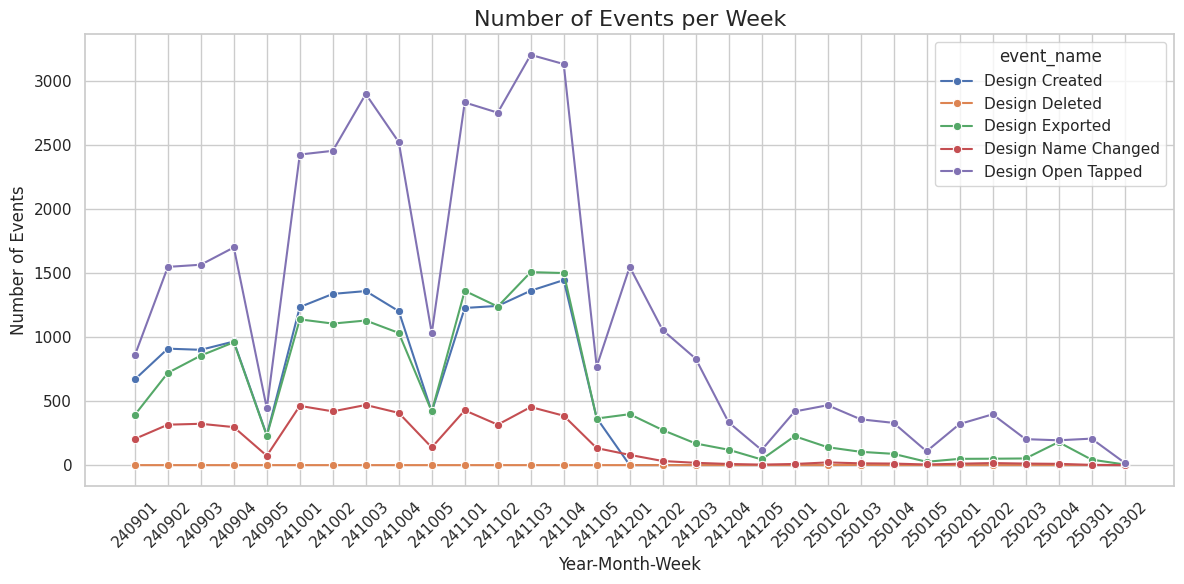

In [49]:
df_melted = df.melt(id_vars=["YMW"],
                    value_vars=["Design Created", "Design Deleted", "Design Exported", "Design Name Changed", "Design Open Tapped"],
                    var_name="event_name",
                    value_name="event_count")

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.lineplot(data=df_melted, x="YMW", y="event_count", hue="event_name", marker="o")
plt.title("Number of Events per Week", fontsize=16)
plt.xlabel("Year-Month-Week", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
cursor.execute("""
    SELECT event_time
    FROM events
    WHERE event_name = 'design_created'
    ORDER BY event_time DESC
    LIMIT 1
""")

last_design_created = cursor.fetchone()

print(f"The row with the last event time for 'design_created' is: {last_design_created }")

The row with the last event time for 'design_created' is: ('2024-11-30 23:40:04.216000',)


####  File_format, Resolution

In [51]:
cursor.execute('''
SELECT COUNT(DISTINCT file_format	) AS file_format
FROM events
''')

files = cursor.fetchall()
headers = ["File Format"]

print(tabulate(files, headers=headers, tablefmt="grid"))

+---------------+
|   File Format |
+===============+
|            12 |
+---------------+


In [52]:
cursor.execute('''
SELECT file_format, COUNT(file_format) as number_files
FROM events
GROUP BY file_format
ORDER BY number_files DESC
''')

files_grouped = cursor.fetchall()
headers = ["Number of file formats"]

print(tabulate(files_grouped , headers=headers, tablefmt="grid"))

+------------+--------------------------+
|            |   Number of file formats |
+============+==========================+
| stl        |                     6369 |
+------------+--------------------------+
| three_mf   |                     4978 |
+------------+--------------------------+
| step       |                     2021 |
+------------+--------------------------+
| shapr      |                     1356 |
+------------+--------------------------+
| dxf_sketch |                      297 |
+------------+--------------------------+
| obj        |                      271 |
+------------+--------------------------+
| svg_sketch |                      243 |
+------------+--------------------------+
| parasolid  |                      201 |
+------------+--------------------------+
| dwg_sketch |                       86 |
+------------+--------------------------+
| usdz       |                       59 |
+------------+--------------------------+
| iges       |                    

In [53]:
cursor.execute('''
SELECT resolution, COUNT(resolution) as reso
FROM events
GROUP BY resolution
ORDER BY reso DESC
''')

resolution = cursor.fetchall()
headers = ["Number of resolutions"]

print(tabulate(resolution, headers=headers, tablefmt="grid"))

+--------+-------------------------+
|        |   Number of resolutions |
+========+=========================+
| high   |                    1730 |
+--------+-------------------------+
| low    |                     574 |
+--------+-------------------------+
| custom |                      47 |
+--------+-------------------------+
|        |                       0 |
+--------+-------------------------+


####  Device platform

In [54]:
cursor.execute('''
SELECT device_platform, COUNT(device_platform) as devpl
FROM events
GROUP BY device_platform
ORDER BY devpl DESC
''')

devpl = cursor.fetchall()
headers = ["Device Platform", "Number of events by platform"]

print(tabulate(devpl, headers=headers, tablefmt="grid"))

+-------------------+--------------------------------+
| Device Platform   |   Number of events by platform |
+===================+================================+
| iOS               |                          33439 |
+-------------------+--------------------------------+
| Windows           |                          28419 |
+-------------------+--------------------------------+
| macOS             |                          11105 |
+-------------------+--------------------------------+
| visionOS          |                              1 |
+-------------------+--------------------------------+


In [55]:
cursor.execute('''
SELECT
    device_platform,
    event_name,
    COUNT(*) AS event_count
FROM events
GROUP BY device_platform, event_name
ORDER BY device_platform, event_name
''')

events_per_platform = cursor.fetchall()
headers = ["platform", "event_name", "event_count"]

print(tabulate(events_per_platform , headers=headers, tablefmt="grid"))

+------------+---------------------+---------------+
| platform   | event_name          |   event_count |
+============+=====================+===============+
| Windows    | design_created      |          5927 |
+------------+---------------------+---------------+
| Windows    | design_exported     |          6579 |
+------------+---------------------+---------------+
| Windows    | design_name_changed |          1700 |
+------------+---------------------+---------------+
| Windows    | design_open_tapped  |         14213 |
+------------+---------------------+---------------+
| iOS        | design_created      |          6713 |
+------------+---------------------+---------------+
| iOS        | design_deleted      |             1 |
+------------+---------------------+---------------+
| iOS        | design_exported     |          6404 |
+------------+---------------------+---------------+
| iOS        | design_name_changed |          2635 |
+------------+---------------------+----------

In [56]:
cursor.execute('''
SELECT
    device_platform,
    SUM(CASE WHEN event_name = 'design_created' THEN 1 ELSE 0 END) AS design_created,
    SUM(CASE WHEN event_name = 'design_deleted' THEN 1 ELSE 0 END) AS design_deleted,
    SUM(CASE WHEN event_name = 'design_exported' THEN 1 ELSE 0 END) AS design_exported,
    SUM(CASE WHEN event_name = 'design_name_changed' THEN 1 ELSE 0 END) AS design_name_changed,
    SUM(CASE WHEN event_name = 'design_open_tapped' THEN 1 ELSE 0 END) AS design_open_tapped
FROM events
GROUP BY device_platform
ORDER BY device_platform
''')

events_per_platform_pivot = cursor.fetchall()


headers = ["Platform", "Design Created", "Design Deleted", "Design Exported", "Design Name Changed", "Design Open Tapped"]
print(tabulate(events_per_platform_pivot, headers=headers, tablefmt="grid"))

+------------+------------------+------------------+-------------------+-----------------------+----------------------+
| Platform   |   Design Created |   Design Deleted |   Design Exported |   Design Name Changed |   Design Open Tapped |
+============+==================+==================+===================+=======================+======================+
| Windows    |             5927 |                0 |              6579 |                  1700 |                14213 |
+------------+------------------+------------------+-------------------+-----------------------+----------------------+
| iOS        |             6713 |                1 |              6404 |                  2635 |                17686 |
+------------+------------------+------------------+-------------------+-----------------------+----------------------+
| macOS      |             2242 |                1 |              2945 |                   750 |                 5167 |
+------------+------------------+-------

####  App version

In [57]:
cursor.execute('''
SELECT COUNT(DISTINCT app_version) AS app_v
FROM events
LIMIT 20
''')

app_v = cursor.fetchall()
headers = ["No of app versions"]

print(tabulate(app_v, headers=headers, tablefmt="grid"))

+----------------------+
|   No of app versions |
+======================+
|                  144 |
+----------------------+


In [58]:
cursor.execute('''
SELECT app_version, COUNT(app_version) as app_v2
FROM events
GROUP BY app_version
ORDER BY app_v2 DESC
LIMIT 10
''')

app_v2 = cursor.fetchall()
headers = ["App versions", "Number of versions"]

print(tabulate(app_v2, headers=headers, tablefmt="grid"))

+----------------+----------------------+
| App versions   |   Number of versions |
+================+======================+
| 5.730.0.7613   |                10291 |
+----------------+----------------------+
| 5.750.0.7750   |                 7278 |
+----------------+----------------------+
| 5.721.0.7564   |                 5251 |
+----------------+----------------------+
| 5.750.7750.0   |                 4981 |
+----------------+----------------------+
| 5.730.7613.0   |                 4830 |
+----------------+----------------------+
| 5.760.0.7837   |                 4827 |
+----------------+----------------------+
| 5.710.0.7459   |                 4558 |
+----------------+----------------------+
| 5.760.7837.0   |                 4550 |
+----------------+----------------------+
| 5.721.7564.0   |                 3645 |
+----------------+----------------------+
| 5.700.0.7412   |                 3417 |
+----------------+----------------------+


In [59]:
conn.close()